# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.387830,False,-2.384340
1,-0.954144,False,-0.603622
2,1.060158,True,6.159996
3,0.562880,True,5.084277
4,0.266384,True,6.226355
...,...,...,...
995,-0.712586,False,-2.522322
996,1.104714,True,6.664937
997,-1.450275,False,-3.058153
998,-0.204456,True,5.178846


<AxesSubplot:xlabel='v0'>

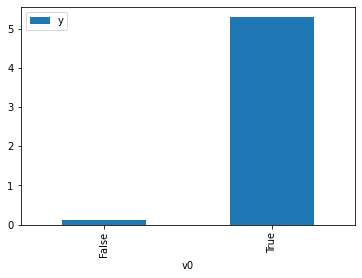

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

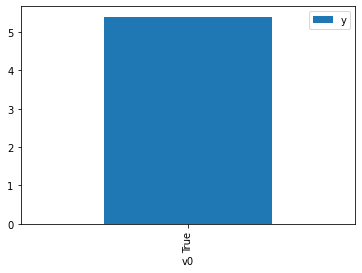

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.657508,False,1.054120,0.212788,4.699505
1,-0.070296,False,0.218704,0.532183,1.879054
2,0.646742,False,-0.469685,0.216371,4.621694
3,-1.898073,False,-4.614947,0.976752,1.023801
4,-0.251772,False,-1.696676,0.619458,1.614314
...,...,...,...,...,...
995,0.406099,False,0.329023,0.307513,3.251895
996,-0.878608,False,-2.552727,0.848770,1.178175
997,-2.324263,False,-3.282124,0.989845,1.010259
998,0.593348,False,2.084728,0.234781,4.259295


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.192446,True,7.235607,0.596258,1.677127
1,1.729745,True,8.105612,0.968490,1.032536
2,0.423077,True,6.191915,0.699579,1.429430
3,0.600202,True,6.882376,0.767642,1.302690
4,0.824874,True,6.620500,0.837355,1.194237
...,...,...,...,...,...
995,1.593659,True,5.926406,0.959172,1.042566
996,-0.879425,True,3.220341,0.151023,6.621517
997,2.465324,True,10.859419,0.992444,1.007613
998,-1.151849,True,2.935731,0.094104,10.626557


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.959
Model:                            OLS   Adj. R-squared (uncentered):              0.959
Method:                 Least Squares   F-statistic:                          1.181e+04
Date:                Thu, 28 Jul 2022   Prob (F-statistic):                        0.00
Time:                        19:51:00   Log-Likelihood:                         -1397.0
No. Observations:                1000   AIC:                                      2798.
Df Residuals:                     998   BIC:                                      2808.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.6597      0.034     48.134      0.000       1.592       1.727
x2             5.0147      0.049    102.260      0.000       4.918       5.111
==============================================================================
Omnibus:                        1.338   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.512   Jarque-Bera (JB):                1.368
Skew:                           0.045   Prob(JB):                        0.504
Kurtosis:                       2.843   Cond. No.                         1.94
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""